In [260]:
##########################################################################

## service Clustring Dataset 2.0 json format							##

##########################################################################
## Format: parameters 		##
## Format: (1) id						exampl: f73b9c6207fd42e3adc4b51a8f8fc5df    ##
## Format: (2) _type					exampl: REST    ##
## Format: (3) source					exampl: https://www.programmableweb.com/api/openstreetmap-rest-api-v06##
## Format: (4) category					exampl: Mapping ##
## Format: (5) url						exampl: http://api.openstreetmap.org/   ##
## Format: (7) description				exampl: OpenStreetMap is the free wiki world map,##
## Format: (8) quality					exampl: null##
##########################################################################


# Service Classification_ Step1: clustering

There is 3 major solutions for ML approaches:

1.	supervised learning

2.	unsupervised learning

3.	hybrid model by combining unsupervised and supervised learning


Most of the web service repositories have a category field to identify their service functionality. therefore, we used the category field as our dataset label. But the main problem is those categories have too much variety. For example, for 6535 services we had 503 categories. 
To solve this problem, we can use a hybrid model by combining unsupervised and supervised learning. Therefore, before service classification, we used cluster services to reduce categories(sections)



## Clustering

The objective of this section is to explore the data and to select a proper clustering algorithm. In our implementation, we used some popular clustering algorithms:

 * K-Means Clustering

 * Agglomerative Hierarchical Clustering


We have tried K-Means algorithm and hierarchical agglomerative clustering. SO, regarding following reason we select hierarchical agglomerative clustering method:

* We will use this clustering method to cluster our dataset, therefore it will happen one time so we don’t care about time complexity of O(n³), Also our dataset is not huge.

* Hierarchical clustering does not require us to specify the number of clusters.

* The tree diagram plot (dendrogram)of Hierarchical clustering makes more sense to understand categories that are close together.


In [261]:
# !pip install -r requirements.txt
# !conda install -c conda-forge wordcloud=1.6.0 -y
# !pip install folium
# !pip install pandas
# !pip install requests 
# !pip install  nltk
# !pip install requests 
# !pip install  unidecode
# !pip install matplotlib
# !pip install matplotlib
# !pip install seaborn

In [262]:
# Data Structures
import numpy  as np
import pandas as pd
import json
import os
import csv

# Corpus Processing
import re
import nltk.corpus
from unidecode                        import unidecode
from nltk.tokenize                    import word_tokenize
from nltk                             import SnowballStemmer
from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.preprocessing            import normalize

import nltk
nltk.download('stopwords')
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import re
import sys
import warnings

# K-Means
from sklearn import cluster

# Visualization and Analysis
import matplotlib.pyplot  as plt
import matplotlib.cm      as cm
import seaborn            as sns
from sklearn.metrics  import silhouette_samples, silhouette_score
from wordcloud                        import WordCloud


#import branca.colormap as cm
from branca.element import Figure

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bisite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [263]:
df=pd.read_json (r'secound_service_2.json',lines=True)
print ('Number of data points : ', df.shape[0], \
       '\n Number of features/variables:', df.shape[1])


print(df.category.nunique())
df.head(3)

Number of data points :  6535 
 Number of features/variables: 9
363


,_id,source,_type,name,url,category,description,methods,docs
0,0016fe9d99b1408d83a9e304d8d83fc2,https://www.programmableweb.com/api/paysbuy-rpc-api,RPC,Paysbuy API,https://www.paysbuy.com/developers.aspx?l=e,Payments,"The service headquartered in Thailand provides for online payments by credit card through familiar networks such as Paypal, MasterCard, Visa, and others. It enables e-commerce and online business overall by quickly and securely processing payments. Sample code is available for PHP/MySQL and .NET environments.\nAPI methods support retrieving invoice data and status information about an invoice. Methods also support uploading current payment information including payor, card and account information, and purchase invoice including product and price. The API also manages currency rates and other details of international transactions.",[],https://www.paysbuy.com/developers.aspx?l=e
1,00222ddc19354471a1bf2ac186db92a0,https://www.programmableweb.com/api/clickmeter-rest-api-v20,REST v2.0,Clickmeter API,https://apiv2.clickmeter.com,Email,"The service monitors responses by recipients of marketing communications to allow evaluation and comparison of their effectiveness. It detects click events on promotional email and other online marketing resources, estimates overall traffic volume, and reports on conversion events resulting from communications. It also detects click-fraud to evaluate reliability of traffic analytics.\nAPI methods support creating links to allow traffic monitoring, including links specifically for conversion events, specific campaigns, specific languages, and other elements of an overall marketing campaign. Methods also support retrieval of links with specific URL patterns to allow both aggregated and detailed reporting on traffic logged.",[],https://apiv2.clickmeter.com
2,002860aed28445588aeaf4f116f1b2cd,https://www.programmableweb.com/api/merriam-webster-dictionary-rest-api-v30,REST v3.0,Merriam-Webster Dictionary API,http://www.dictionaryapi.com/api/,Dictionary,"The Merriam-Webster Dictionary API gives developers access to a comprehensive resource of dictionary and thesaurus content as well as specialized medical, Spanish, ESL, and student-friendly vocabulary. Make your applications better by integrating our authoritative definitions, etymologies, audio pronunciations, synonyms and antonyms, and more. Merriam-Webster has been producing language information including dictionaries, thesauri, and translation materials for over 150 years. The Merriam-Webster collection of APIs provide developer access to a variety of the company's most prominent reference works. Free access is provided to non-commercial websites and applications. Free access is limited to two reference works with a maximum of 1000 queries a day per reference work. Full access is available for commercial use.",[],http://www.dictionaryapi.com/api/


363


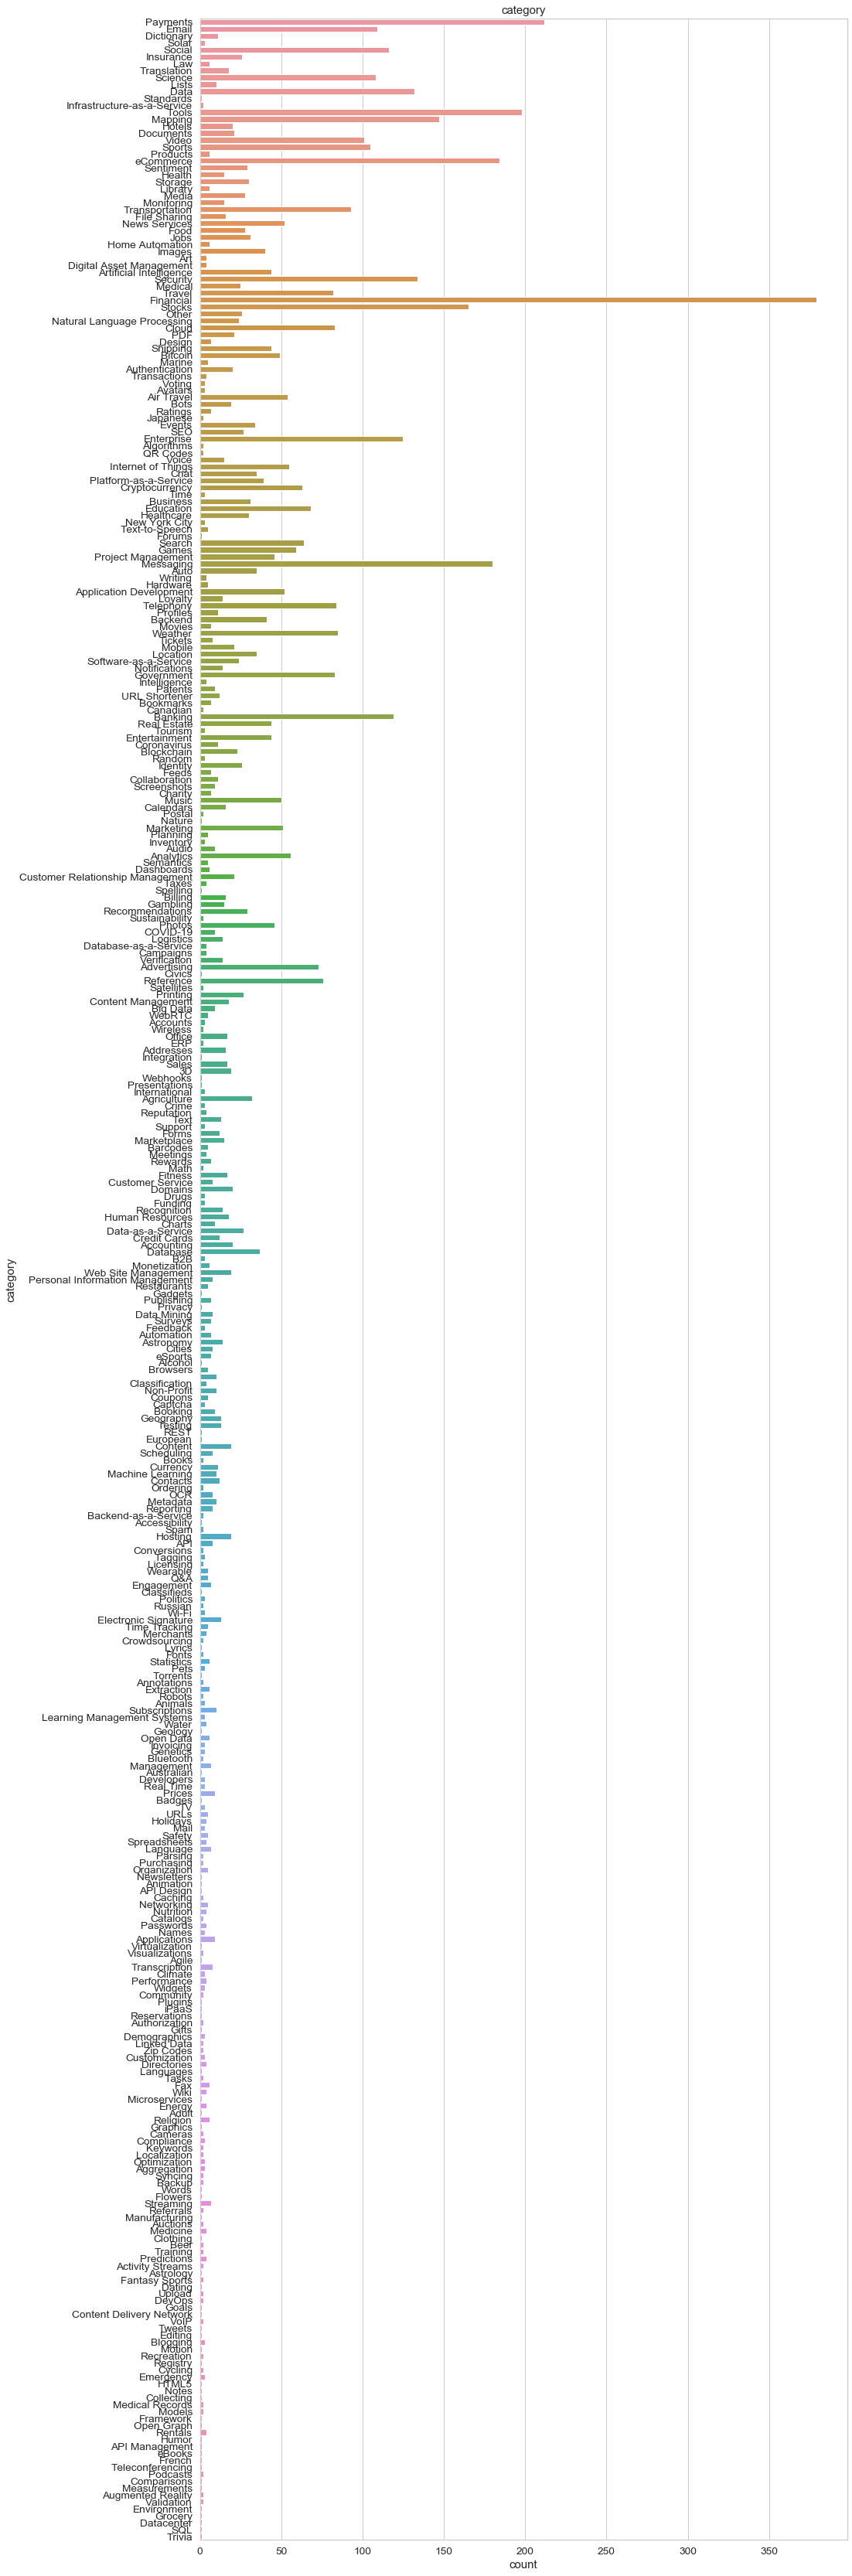

In [264]:

fg, axs = plt.subplots(1, 1, figsize=(15,60))

ax = sns.countplot(y="category", data=df)
plt.title('category')
print(df.category.nunique())

## Pre Processing

1- convert universal type for services for example REST V2 and REST V1 will RESt. In current approches we ignore service resrt versioning and focus on service description.

In [265]:
#preprocessing
df2=df
df2.loc[df['_type'].str.contains('REST', regex=True)==True, "_type"] = "REST"
df2.loc[df['_type'].str.contains('RPC', regex=True)==True, "_type"] = "RPC"
df2.loc[df['_type'].str.contains('FEED', regex=True)==True, "_type"] = "FEED"
df2.loc[df['_type'].str.contains('Indirect', regex=True)==True, "_type"] = "Indirect"
df2.loc[df['_type'].str.contains('Streaming', regex=True)==True, "_type"] = "Streaming"
df2.loc[df['_type'].str.contains('Unspecified', regex=True)==True, "_type"] = "Unspecified"
df2.loc[df['_type'].str.contains('Native/Browser', regex=True)==True, "_type"] = "Native/Browser"


List_Of_Categories_In_Column=list(df2['_type'].value_counts().index)
List_Of_Categories_In_Column

['REST',
 'RPC',
 'Streaming',
 'Unspecified',
 'Indirect',
 'Native/Browser',
 'FEED',
 'EMAIL/MESSAGING/FTP',
 '']

## Remove useless coulmns

In [266]:
df3=df2.drop(['_id'],errors='ignore', axis=1)
df3=df3.drop(['_type'], errors='ignore', axis=1)
df3=df3.drop(['source'] ,errors='ignore', axis=1)
df3=df3.drop(['methods'], errors='ignore', axis=1)
df3=df3.drop(['url'], errors='ignore', axis=1)
df3=df3.drop(['docs'], errors='ignore', axis=1)

df3

,name,category,description
0,Paysbuy API,Payments,"The service headquartered in Thailand provides for online payments by credit card through familiar networks such as Paypal, MasterCard, Visa, and others. It enables e-commerce and online business overall by quickly and securely processing payments. Sample code is available for PHP/MySQL and .NET environments.\nAPI methods support retrieving invoice data and status information about an invoice. Methods also support uploading current payment information including payor, card and account information, and purchase invoice including product and price. The API also manages currency rates and other details of international transactions."
1,Clickmeter API,Email,"The service monitors responses by recipients of marketing communications to allow evaluation and comparison of their effectiveness. It detects click events on promotional email and other online marketing resources, estimates overall traffic volume, and reports on conversion events resulting from communications. It also detects click-fraud to evaluate reliability of traffic analytics.\nAPI methods support creating links to allow traffic monitoring, including links specifically for conversion events, specific campaigns, specific languages, and other elements of an overall marketing campaign. Methods also support retrieval of links with specific URL patterns to allow both aggregated and detailed reporting on traffic logged."
2,Merriam-Webster Dictionary API,Dictionary,"The Merriam-Webster Dictionary API gives developers access to a comprehensive resource of dictionary and thesaurus content as well as specialized medical, Spanish, ESL, and student-friendly vocabulary. Make your applications better by integrating our authoritative definitions, etymologies, audio pronunciations, synonyms and antonyms, and more. Merriam-Webster has been producing language information including dictionaries, thesauri, and translation materials for over 150 years. The Merriam-Webster collection of APIs provide developer access to a variety of the company's most prominent reference works. Free access is provided to non-commercial websites and applications. Free access is limited to two reference works with a maximum of 1000 queries a day per reference work. Full access is available for commercial use."
3,Clean Power Research Solar Simulations API,Solar,"Clean Power Research builds services for energy calculation, simulation, and automation. The Clean Power Research Solar Simulations API provides access to irradiance and weather data. All Solar Simulation API methods support XML. The API can simulate PV output to receive AC energy production, Plane Of Array Irradiance (POAI), solid and liquid precipitation, and more."
4,Shoudio API,Social,"Shoudio is a location based audio platform that lets users record and share geo-tagged audio snippets with friends via Shoudio.com, Twitter, Facebook and Foursquare. The API lets developers retrieve data and post shoudios of their own. The API uses RESTful calls and responses are formatted in JSON."
...,...,...,...
6530,Sift Score API,Security,"Sift Score API is a REST API that provides a risk score for users on an e-commerce website. The Sift score for users are assessed through JSON requests containing an API key and user id and provides a JSON response. This API allows for HTTP notifications to endpoints of the company's choice and up to two hundred daily email notifications.Sift Science is a company focused on monitoring website's traffic and events and protecting sites from users intent on malicious activities such as: fraud, credit card chargebacks, money laundering, abuse of referral programs, and general spamming."
6531,MessageBird Personal Data API,Messaging,"The MessageBird Personal Data API is currently in beta. It allows you to send data requests based on multiple identifiers to search for information about a specific Data Subject that includes telephone numbers, email addresses, and IP addresses. MessageBi

## Description to lowercase

In [267]:
df4=df3
df4['description']=df4['description'].str.lower()

## Remove None / Null value from description¶


In [268]:
df4 = df4[pd.notnull(df4['description'])]
df4
print(df4.category.nunique())

363


## Remove category with low frequency


In [269]:
counts_category = df4.groupby("category")["category"].transform(len)

mask_will_remove = (counts_category < 30)
df_will_remove=df4
df_will_remove=df4[mask_will_remove]
# df_will_remove



## Display Removed categories

309


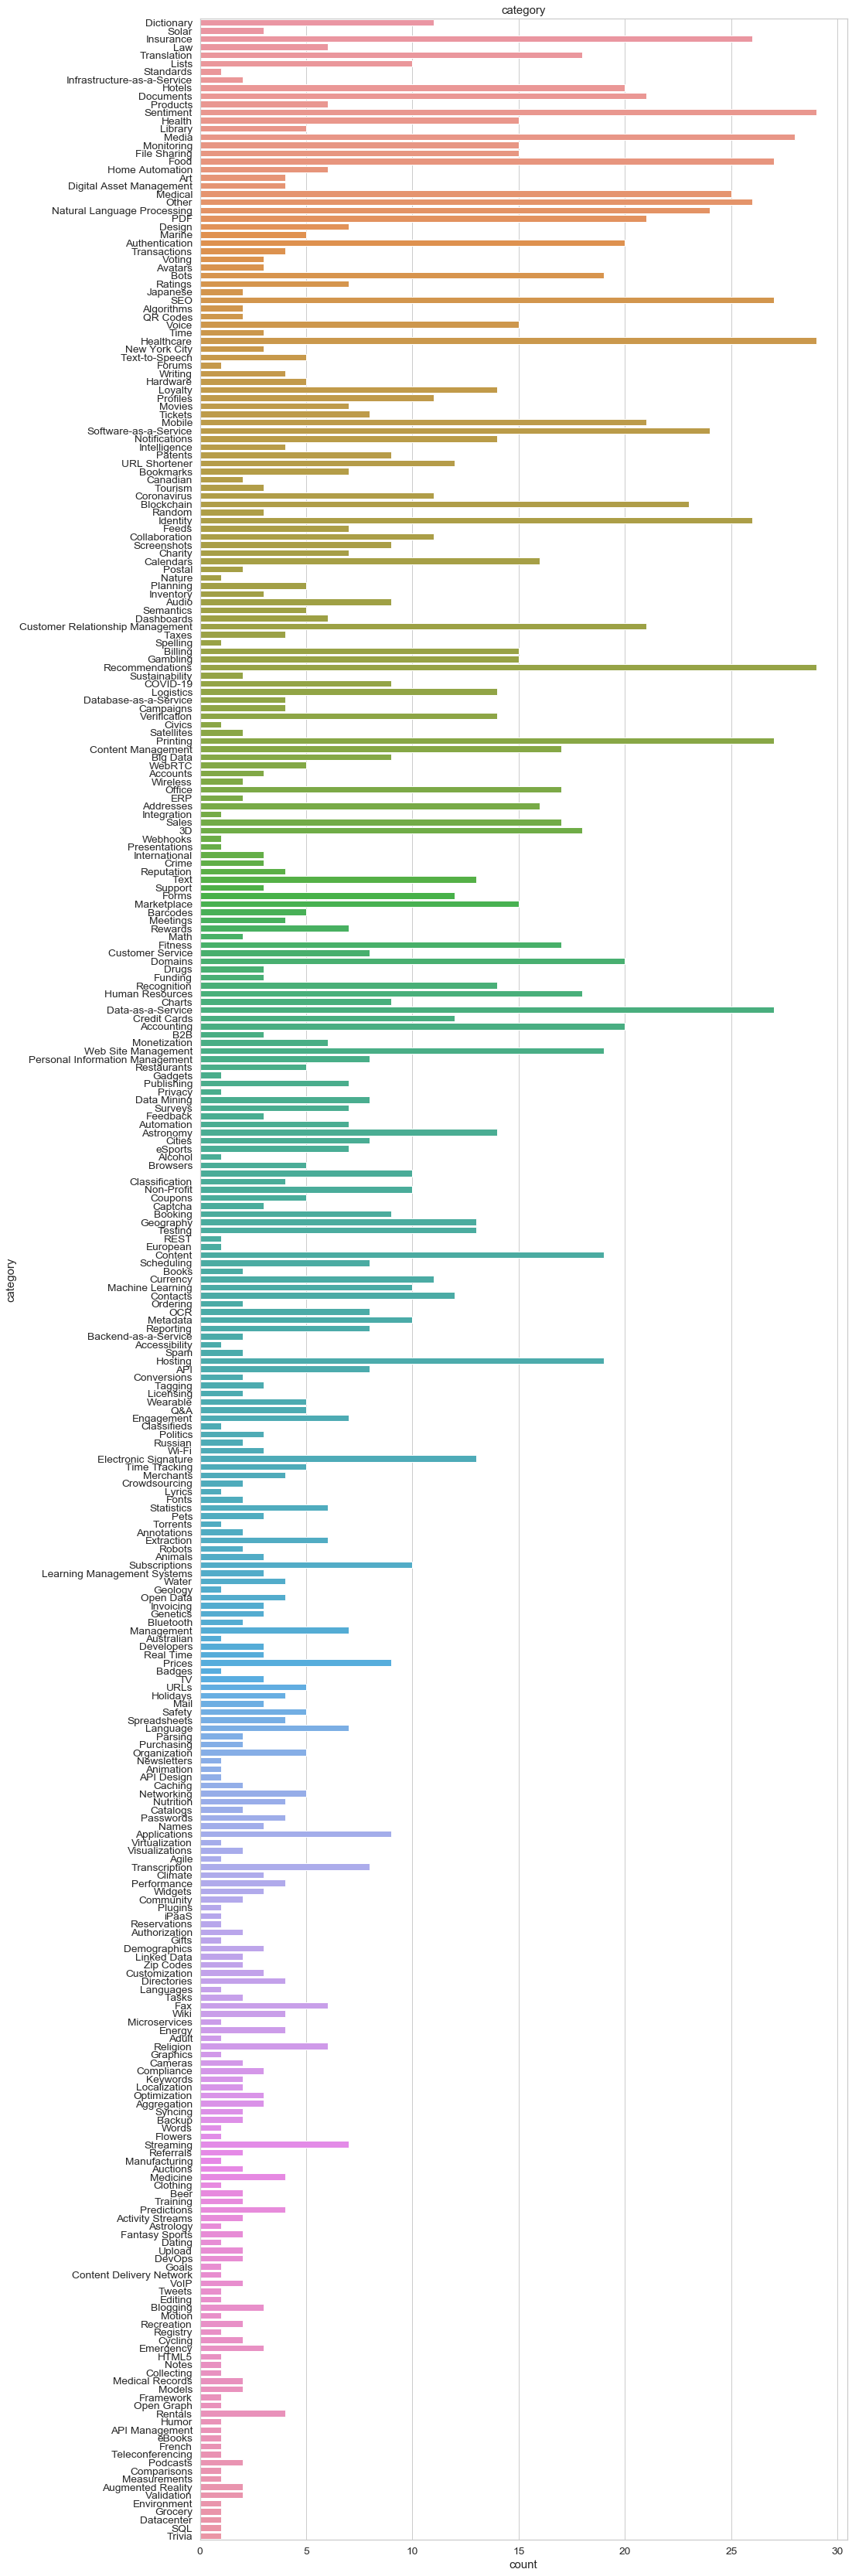

In [270]:

fg, axs = plt.subplots(1, 1, figsize=(15,60))

ax = sns.countplot(y="category", data=df_will_remove)
plt.title('category')
print(df_will_remove.category.nunique())

In [271]:
counts_category = df4.groupby("category")["category"].transform(len)

mask = (counts_category > 30 )

df4=df4[mask]
# df4


## Display selected categories

53


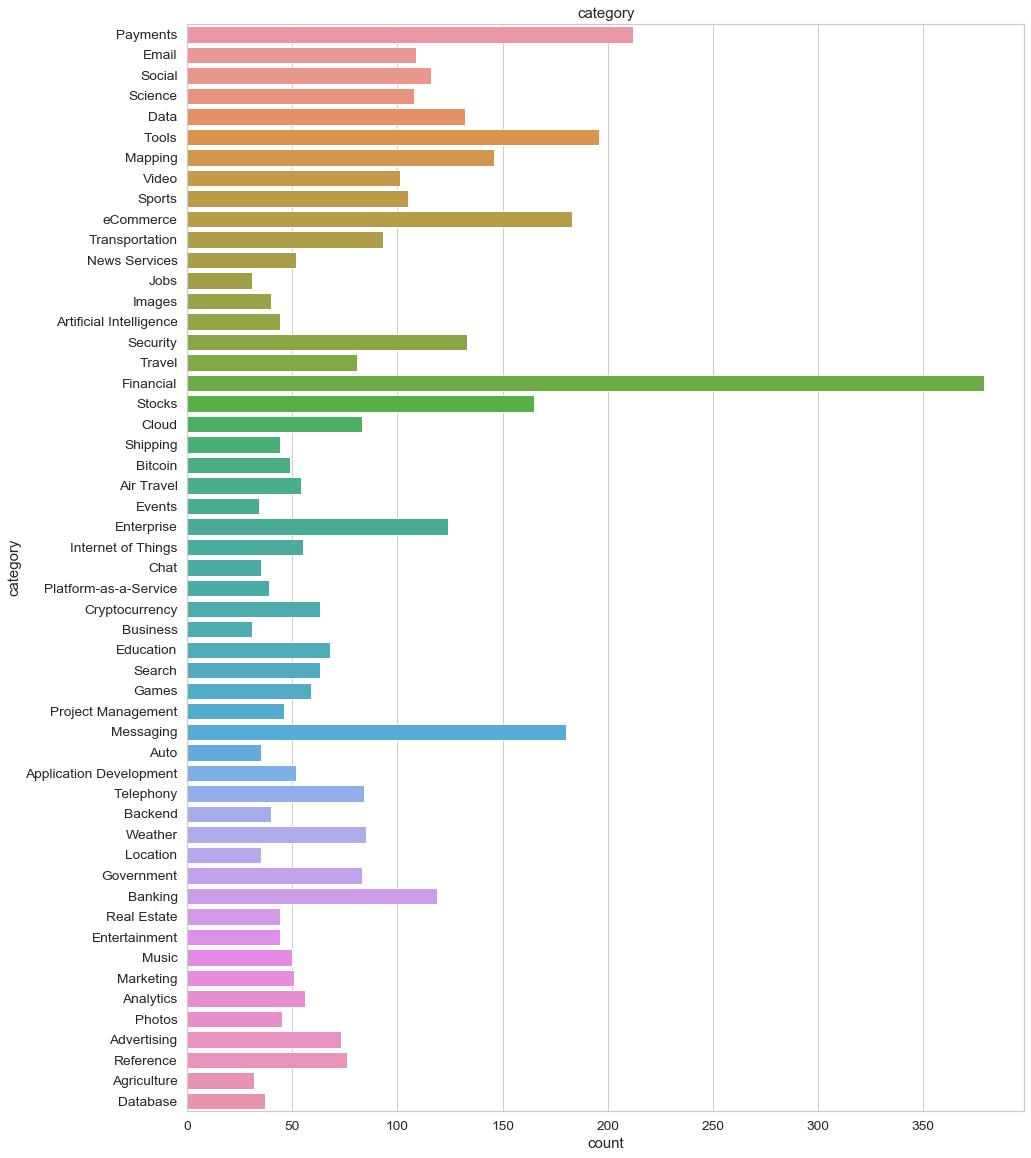

In [272]:
fg, axs = plt.subplots(1, 1, figsize=(15,20))

ax = sns.countplot(y="category", data=df4)
plt.title('category')
df4.category.value_counts()
# to see how many unique value is in column
print(df4.category.nunique())

## Remove Stopwordsand + Punctuation or special characters

In [273]:
import nltk
nltk.download('stopwords')

#function to clean the word of any punctuation or special characters
def cleanPunc(sentence): 
    cleaned = re.sub(r'[?|!|\[|\]|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|)|(|\|/]',r' ',cleaned)
    cleaned = re.sub(r'[\d]',r' ',cleaned)#remove digite
    cleaned = cleaned.strip()
    cleaned = cleaned.replace("\n","")
    return cleaned

df4['description'] = df3['description'].astype(str).apply(cleanPunc)
df4['description']

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bisite/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0       the service headquartered in thailand provides for online payments by credit card through familiar networks such as paypal, mastercard, visa, and others  it enables e-commerce and online business overall by quickly and securely processing payments  sample code is available for php mysql and  net environments api methods support retrieving invoice data and status information about an invoice  methods also support uploading current payment information including payor, card and account information, and purchase invoice including product and price  the api also manages currency rates and other details of international transactions                                                                                             
1       the service monitors responses by recipients of marketing communications to allow evaluation and comparison of their effectiveness  it detects click events on promotional email and other online marketing resources, estimates overall traffic volume, and rep

In [274]:
#function for remove stop words, for example google should remove?
stop_words = set(stopwords.words('english'))
stop_words.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten',
                   '1','2','3','4','5','6','7','8','9','10',
                   'may','also','across','among','beside','however','yet','within','many',
                   'first','second','third','fifth','this','the','monthly',"google","yahoo","Google","Yahoo","api"])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)

def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)

df5 = df4
df5['description'] = temp['description'].apply(removeStopWords)
df5['description']


0        headquarter thailand    crit  familiar network paypal master visa others  e commerce   overall quickly securely process  sample   php mysql net environment   retriev invoice    invoice   upload current    payor    purchase invoice     currency rate detail international                                                                                                                                                                        
1        monitor  recipient market communication allow evaluation comparison effectiveness detects click  promotional   market resource estimate overall traffic volume report conversion  result communication detects click fraud evaluate reliability traffic    creat link allow traffic monitor  link specifically conversion   campaign  language element overall market campaign   retrieval link  url pattern allow aggrega detail report traffic logg
4       shoudio   audio    record share geo tagg audio snippet fri via shoudio  twitter facebook foursquar

### Tokenize

In [275]:
nltk.download('punkt')
nltk.download('wordnet')

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.tokenize import WhitespaceTokenizer
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer


df6 = df5
from nltk.tokenize import RegexpTokenizer
tokenizer=RegexpTokenizer(r'\w+')

df6['description'] = df5['description'].apply(lambda x:tokenizer.tokenize(x.lower()))
df6['description']



[nltk_data] Downloading package punkt to /Users/bisite/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/bisite/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0       [headquarter, thailand, crit, familiar, network, paypal, master, visa, others, e, commerce, overall, quickly, securely, process, sample, php, mysql, net, environment, retriev, invoice, invoice, upload, current, payor, purchase, invoice, currency, rate, detail, international]                                                                                                                                                                                                       
1       [monitor, recipient, market, communication, allow, evaluation, comparison, effectiveness, detects, click, promotional, market, resource, estimate, overall, traffic, volume, report, conversion, result, communication, detects, click, fraud, evaluate, reliability, traffic, creat, link, allow, traffic, monitor, link, specifically, conversion, campaign, language, element, overall, market, campaign, retrieval, link, url, pattern, allow, aggrega, detail, report, traffic, logg]
4       [shoudio, audio, record, s

## Lemmatizer

In [276]:
#steming is more brutall for example it removes "e" from words for example change --->chang
#So we select Lemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

def word_lemmatizer(text):
    lem_text=" ".join([lemmatizer.lemmatize(i) for i in text])
    return lem_text

df7=df6
df7['description']=df6['description'].apply(lambda x:word_lemmatizer(x))
df7['description']

0       headquarter thailand crit familiar network paypal master visa others e commerce overall quickly securely process sample php mysql net environment retriev invoice invoice upload current payor purchase invoice currency rate detail international                                                                                                                                                                                    
1       monitor recipient market communication allow evaluation comparison effectiveness detects click promotional market resource estimate overall traffic volume report conversion result communication detects click fraud evaluate reliability traffic creat link allow traffic monitor link specifically conversion campaign language element overall market campaign retrieval link url pattern allow aggrega detail report traffic logg
4       shoudio audio record share geo tagg audio snippet fri via shoudio twitter facebook foursquare post shoudios                       

## Remove High Ferequency words

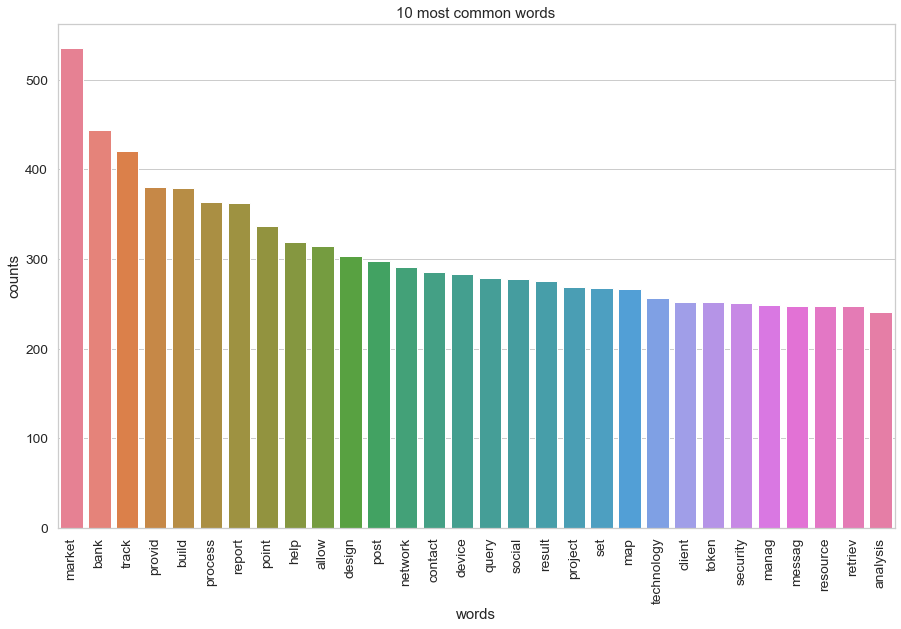

In [277]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as npimport
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

df10=df7

def find_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    return words


def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:30]

    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
    return words
count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df10['description'])# Visualise the 10 most common words
words=plot_10_most_common_words(count_data, count_vectorizer)



In [278]:
# To_remove_lst=words
# df10['description'] = df10['description'].str.replace('|'.join(To_remove_lst), '')
# df10['description']

In [279]:
# count_vectorizer = CountVectorizer(stop_words='english')# Fit and transform the processed titles
# count_data = count_vectorizer.fit_transform(df10['description'])# Visualise the 10 most common words
# words=find_10_most_common_words(count_data, count_vectorizer)

## Remove founded rfrequensed word as stop word
 after several trype found following words and remove as stop words

In [280]:
stop_words = set(stopwords.words('english'))
stop_words.update(['code',
                   'number', 'get', 'us', 'featuer','help', 'online', 'site', 'include', 'open', 'enables', 'real', 'http',
                   "including", "featuers",
                   'application', 'responses', 'stock', 'format', 'offers', 'retrieve', 'calls', 'requests',
                   'functionality', 'key', 'includes', 'customers', 'features', 'location', 'content',
                   'financi', 'management', 'mobile', 'text', 'com', 'base', 'tools', 'public'  'way', 'software',
                   'send', 'company', 'request', 'products', 'specific'   'ful', 'sites', 'day', 'intrinio',
                   'list', 'trading', 'manage', 'authentication', 'customer', 'solutions',
                   'support', 'xml', 'new', 'end', 'make', 'tool', 'supports', 'formatted', 'specific',
                   'provider', 'address', 'public', 'app', 'product', 'global', 'close', 'interface',
                   'managing', 'feed', 'free',
                   'integration', 'retrieving', 'designed', 'provided', 'service', 'format',
                   'analytics', 'results', 'add', 'status', 'historical', 'details', 'apps', 'account', 'data',
                   'provide' , 'service', 'developer', 'user', 'provides', 'system', 'search', 'ful', 'apis', 
                   'al', 'ing', 'es', 'ed', 'use', 'create', 'using', 'used', 'cloud','function', 'let', 'build'
                   'data', 'service', 'developer', 'user', 'provides', 'allows', 'application',
                   'access', 'information', 'json', 'available', 'platform', 'payment',
                   'method','account','exchange', 'price', 'return', 'support','response', 'customer', 'request',  'based',
                   'format', 'integrate', 'rest', 'web','time', 'offer', 'use', 'website', 'back', 'name', 'type', 
                   'example', 'high', 'via ', 'update', 'call', 'restful', 'feature', 'business',  'solution', 'email', 'file'
                   ])
re_stop_words = re.compile(r"\b(" + "|".join(stop_words) + ")\\W", re.I)


def removeStopWords(sentence):
    global re_stop_words
    return re_stop_words.sub(" ", sentence)


df10['description'] = df10['description'].apply(removeStopWords)
df10['description']


0       headquarter thailand crit familiar network paypal master visa others e commerce overall quickly securely process sample php mysql net environment retriev invoice invoice upload current payor purchase invoice currency rate detail international                                                                                                                                                                                    
1       monitor recipient market communication allow evaluation comparison effectiveness detects click promotional market resource estimate overall traffic volume report conversion result communication detects click fraud evaluate reliability traffic creat link allow traffic monitor link specifically conversion campaign language element overall market campaign retrieval link url pattern allow aggrega detail report traffic logg
4       shoudio audio record share geo tagg audio snippet fri via shoudio twitter facebook foursquare post shoudios                       

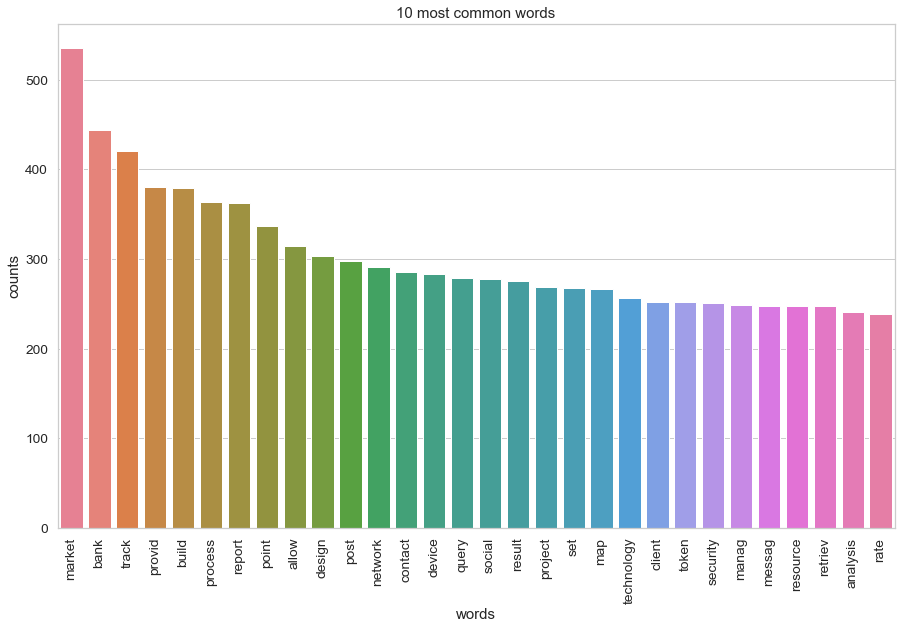

In [281]:
count_vectorizer2 = CountVectorizer(stop_words='english')# Fit and transform the processed titles
count_data2 = count_vectorizer2.fit_transform(df10['description'])# Visualise the 10 most common words
words2=plot_10_most_common_words(count_data2, count_vectorizer2)

# Clustering

Now we are going to clustered dataset using hierarchical clustering. 

## Group By all category
we need to group by all category to just cluster categories

In [282]:
df_groupedby=df10.groupby('category').agg({'name':'sum', 'description':'first','category':'first'})
# df_groupedby.to_csv('groped_by_category_filterd.csv', index = False, header=True)
df10=df_groupedby


## Convert to list all desc

In [283]:
corpus = df10['description'].tolist()
corpus[18][0:447]

'cyfe dashboard  monitor analyze different place cyfe push cyfe main push dashboard channel'

In [284]:
corpus[18][0:460]
corpus

['faxem direct market australia fax market  reach client faxem faxem stream party automate task directly perform operation delete rpc secure port requir',
 'usda agriculture resource survey arm display analyze view agricultural authenticate r run sample graphql',
 'iag british air destination airport city serv british air shar parameter requir ne register sign mashery id british air provid international airline group iag combine lead airline ireland spain uk enhance presence aviation market',
 'incites document level metric current cris performance metric paper cri institution clarivate leader provid trus insight accelerate pace innovation',
 'ever graphql mutable query common set utility associa ip currency language markdown conversion ever plan community ever focus logic provid faster query faster development',
 'valossa power deep learn neural network aim valossa voice enabl natural language process ints film analysis detect thousand associa concept theme word valossa core design au

# NLP Strategy 
IN NLP There are two technique:

     1-bags of words (our current approach)
     2-Word Embedding

IN Word Embedding , number of dimension is fixed no matter how large the corpus is. (good for in-balanced data) Comparing to bags of words that number of dimension will be increased when unique word increase.

regardingour datasetis medium now we use bag of words

## Bag of word Sterategy (BOW)

In [285]:
from sklearn.feature_extraction.text import TfidfVectorizer



vectorizer = TfidfVectorizer(stop_words='english',  max_df=0.7)
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data = X.toarray(), columns=vectorizer.get_feature_names())
# (tf_idf * tf_idf.T).A #similarities matrix of sentences

### Statistical Weighting of Words

Now we will apply the [TF-IDF]function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [286]:
vectorizer = TfidfVectorizer(stop_words='english',  max_df=0.7)
vectorizer = vectorizer.fit_transform(corpus)
vectors=vectorizer.toarray()

vectors

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09133652, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Hierarchical cluster

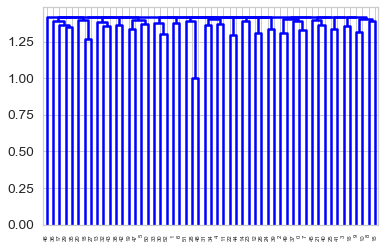

In [287]:
# Agglomerative Clustering
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hac
tree = hac.linkage(vectors, method="complete",metric="euclidean")
plt.clf()
hac.dendrogram(tree)
plt.show() 

In [288]:
from scipy.cluster.hierarchy import fcluster
clustering = fcluster(tree,20,'maxclust')
print(clustering)

[15  8 15 18 10  6  8 15 20 19 19 10 13  4 12 20 18  1  2  6  2 16 11 12
 14 17 13  2  9  1  7 10  4  7 10  1  1 15  5 14 16 17  5  4 11 16  3  6
  9 15  6  9  7]


In [289]:
labels =clustering
df10['cluster_'] = labels
df10[['cluster_','category']]

,cluster_,category
category,,
Advertising,15,Advertising
Agriculture,8,Agriculture
Air Travel,15,Air Travel
Analytics,18,Analytics
Application Development,10,Application Development
Artificial Intelligence,6,Artificial Intelligence
Auto,8,Auto
Backend,15,Backend
Banking,20,Banking


In [290]:
df_groupedby2=df10.groupby(['cluster_'], as_index=False)\
.agg({ 'category':lambda x: ','.join(x)})
df17=df_groupedby2
pd.set_option('display.max_colwidth', -1)
df17[['cluster_','category']].tail(50)

,cluster_,category
0,1,"Email,Marketing,Platform-as-a-Service,Project Management"
1,2,"Enterprise,Events,Location"
2,3,Telephony
3,4,"Cryptocurrency,News Services,Social"
4,5,"Reference,Shipping"
5,6,"Artificial Intelligence,Entertainment,Tools,Video"
6,7,"Messaging,Payments,eCommerce"
7,8,"Agriculture,Auto"
8,9,"Mapping,Transportation,Weather"
9,10,"Application Development,Chat,Music,Photos"


## Provide clusterd Dataset: 

merge origin database Labels based on clustering Result


27
24


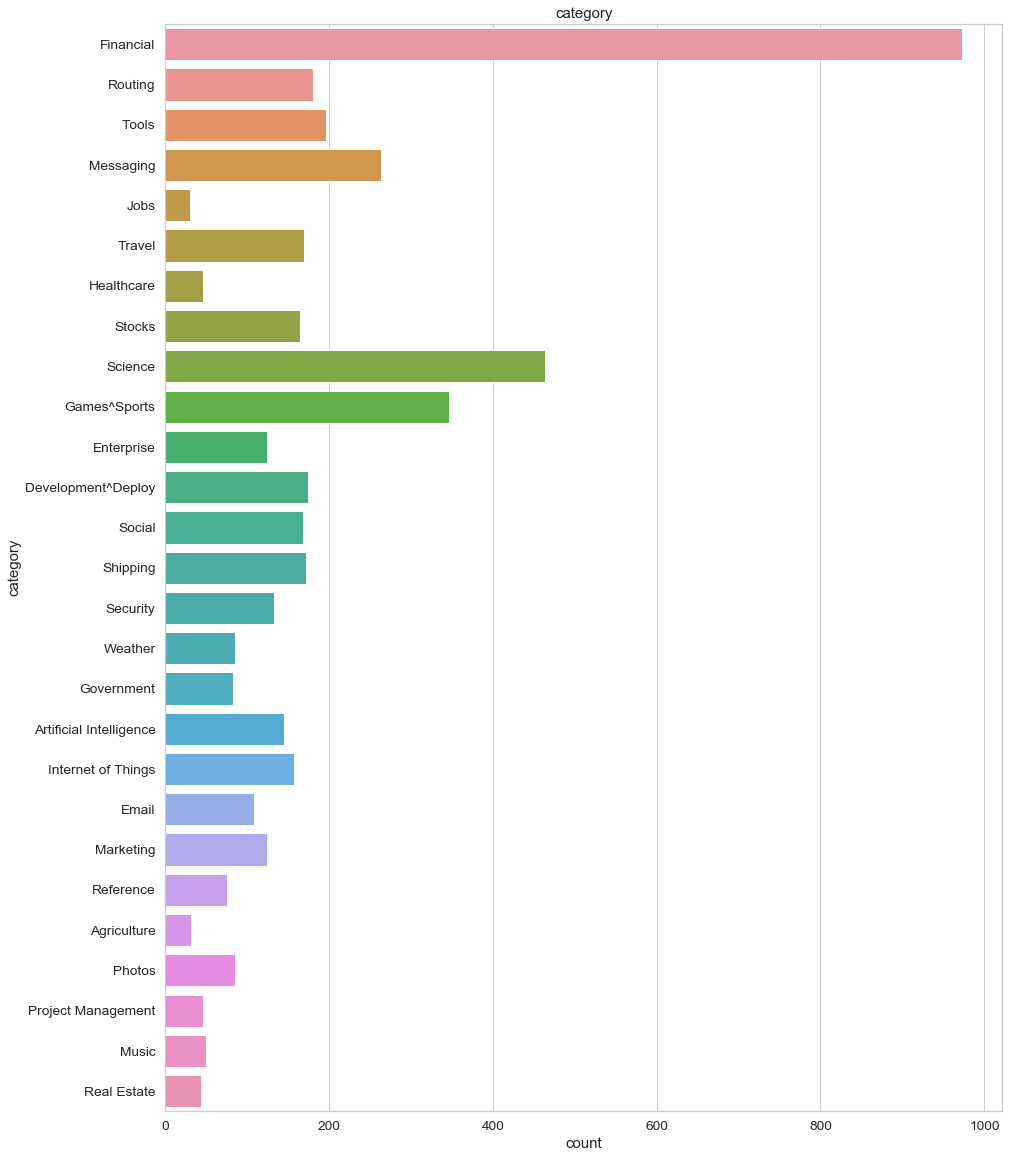

In [291]:
df=pd.read_json (r'secound_service_2.json',lines=True)

### Remove None / Null value from description
df2_=df
df2_ = df2_[pd.notnull(df['description'])]

##thereare some usefull but small groups that we need keep them in our dataset before remove low frequency categories
df_small_usefull_cat = df2_[ 
                            (df2_['category'] == 'Fitness')
                           | (df2_['category'] == 'Healthcare')
#                            | (df2_['category'] == '3D')
                           | (df2_['category'] == 'Sports')
                           | (df2_['category'] == 'Natural Language processing')
                               

                           ]



### Remove categorieswith low frequency
counts_category = df2_.groupby("category")["category"].transform(len)

mask = (counts_category > 30)

df3_=df2_[mask]

# Stack the DataFrames on top of each other
df3_ = pd.concat([df3_, df_small_usefull_cat], axis=0)
df3_ = df3_.sample(frac=1).reset_index(drop=True)

df3_

#mergecategory labels

fg, axs = plt.subplots(1, 1, figsize=(15,20))
# df3_.loc[df3_['category'].astype(str).str.contains('Monitoring|Software-as-a-Service|Tools|Application Development', regex=True)==True, "category"] = "Software-as-a-Service"

df3_.loc[df3_['category'].astype(str).str.contains('Fitness|Healthcare', regex=True)==True, "category"] = "Healthcare"

df3_.loc[df3_['category'].astype(str).str.contains('Data|Search|Analytics|Education|Science', regex=True)==True, "category"] = "Science"

df3_.loc[df3_['category'].astype(str).str.contains('Location|Mapping', regex=True)==True, "category"] = "Routing"
df3_.loc[df3_['category'].astype(str).str.contains('Chat|Shipping|Transportation', regex=True)==True, "category"] = "Shipping"
# df3_.loc[df3_['category'].astype(str).str.contains('Data|Search', regex=True)==True, "category"] = "Data"
# df3_.loc[df3_['category'].astype(str).str.contains('Cloud|Location', regex=True)==True, "category"] = "Cloud"
# df3_.loc[df3_['category'].astype(str).str.contains('Bitcoin|Business', regex=True)==True, "category"] = "Business"
df3_.loc[df3_['category'].astype(str).str.contains('Games|Sports|Entertainment|Events', regex=True)==True, "category"] = "Games^Sports"

# df3_.loc[df3_['category'].astype(str).str.contains('Payments|eCommerce', regex=True)==True, "category"] = "eCommerce"
df3_.loc[df3_['category'].astype(str).str.contains('Natural Language processing|Artificial Intelligence|Video', regex=True)==True, "category"] = "Artificial Intelligence"
# df3_.loc[df3_['category'].astype(str).str.contains('Analytics|Education', regex=True)==True, "category"] = "Education"
df3_.loc[df3_['category'].astype(str).str.contains('Messaging|Telephony', regex=True)==True, "category"] = "Messaging"
df3_.loc[df3_['category'].astype(str).str.contains('Bitcoin|Business|Banking|Financial|Payments|eCommerce', regex=True)==True, "category"] = "Financial"

df3_.loc[df3_['category'].astype(str).str.contains('Application Development|Cloud|Backend', regex=True)==True, "category"] = "Development^Deploy"
df3_.loc[df3_['category'].astype(str).str.contains('News Services|Social', regex=True)==True, "category"] = "Social"

df3_.loc[df3_['category'].astype(str).str.contains('Images|Photos', regex=True)==True, "category"] = "Photos"
df3_.loc[df3_['category'].astype(str).str.contains('Air Travel|Travel|Auto', regex=True)==True, "category"] = "Travel"
df3_.loc[df3_['category'].astype(str).str.contains('Platform-as-a-Service|Blockchain|Cryptocurrency|Internet of Things', regex=True)==True, "category"] = "Internet of Things"
df3_.loc[df3_['category'].astype(str).str.contains('Advertising|Marketing', regex=True)==True, "category"] = "Marketing"


ax = sns.countplot(y="category", data=df3_)
plt.title('category')
print(df3_.category.nunique())
# df3_

#remove some classes
indexNames =df3_[ 
    (df3_['category'] == 'Tools')
#   | (df3_['category'] == 'Software-as-a-Service')
#   | (df3_['category'] == 'Platform-as-a-Service')
    | (df3_['category'] == 'Reference')
#   | (df3_['category'] == 'Project Management')
    | (df3_['category'] == 'Enterprise')].index

df3_.drop(indexNames , inplace=True)

print(df3_.category.nunique())

In [292]:
df3_.shape


(4249, 9)

In [293]:
df3_.shape


(4249, 9)

# Drop use less column

_type : it is not important for service seatuers, also due to noise

NaMe : the name are spechial and due to noise

source : it is not important for service seatuers, also due to noise

_id : random data

methods : most of it is missed value andit has not data 

url : we dont need in ourclassification process


url : it content url value and we dont need in ourclassification process

In [294]:
df_3_=df3_.drop(['_id'],errors='ignore', axis=1)
df_3_=df_3_.drop(['source'] ,errors='ignore', axis=1)
df_3_=df_3_.drop(['methods'], errors='ignore', axis=1)
df_3_=df_3_.drop(['url'], errors='ignore', axis=1)
df_3_=df_3_.drop(['docs'], errors='ignore', axis=1)
df_3_=df_3_.drop(['_type','name'],errors='ignore', axis=1)
df_3_.head(4)

##Drop

,category,description
0,Financial,"Bibox is a Chinese digital asset exchange marketplace. The Bibox API provides a RESTful Access to the Bibox trading platform. Methods are available for contract trading, spot trading, transfer access, and credit training. The API conveys requests in URI Query String/CRUD format."
1,Routing,"This API grants access to Mapbox resources on behalf of a user. All accounts have a public token by default. Additional tokens can be created to grant additional, or more limited, privileges. Mapbox is an open source mapping platform for developers. Mapbox is an open source mapping platform for developers."
3,Messaging,"CallHub API lets you get notifications from CallHub campaigns as webhooks. You can also add new contacts, start or stop campaigns, create volunteers for phone banks and create teams of volunteers"
4,Financial,"The ABN-AMRO Payment Initiation API returns data to initiate payments and retrieve information on the status of the transaction. Developers need a PSD2 license to use this service. They can authenticate with an API Key and make calls that return JSON responses. ABN AMRO Bank is headquartered in Amsterdam, Holland."


In [295]:
# Save clustered/dataset in new CSV file

In [296]:
# df_3_.to_csv('data_before_NLP_preprocessing.csv', index = False, header=True)
df_3_.to_csv('clusterd_services_dataset.csv', index = False, header=True)
